In [1]:
import pandas as pd

In [14]:
data_folder = 'data/sample_data'

B1 = pd.read_csv(data_folder + '/B1.csv', header=None)
print(B1.shape)
B1

(5, 7)


,0,1,2,3,4,5,6
0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,-1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [15]:
B2 = pd.read_csv(data_folder + '/B2.csv', header=None)
print(B2.shape)
B2

(2, 7)


,0,1,2,3,4,5,6
0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,-1.0,0.0,1.0


In [16]:
from sclibrary.read_data import ReadSimplicialComplex

data = ReadSimplicialComplex(B1, B2)
data.get_data_summary()
print("Nodes", data.get_nodes())
print("Edges", data.get_edge_list(rank=1))
print("Triangle Edges", data.get_edge_list(rank=2))
print("Adjacency", data.get_adjacency_matrix())
#graph = data.creat_nx_graph()
#data.draw_graph()

number of nodes:  5
number of edges:  7
number of triangles:  2
Nodes [0, 1, 2, 3, 4]
Edges [(0, 1), (0, 2), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4)]
Triangle Edges [[1, 2, 3], [1, 3, 4]]
Adjacency [[ 0 -1 -1  0  0]
 [ 1  0 -1 -1 -1]
 [ 1  1  0 -1  0]
 [ 0  1  1  0 -1]
 [ 0  1  0  1  0]]


In [17]:
from sclibrary.simplicial_complex import SimplicialComplexNetwork

edge_list = data.get_edge_list()
sc = SimplicialComplexNetwork(edge_list)
sc.hodge_laplacian_matrix(rank=1)

matrix([[ 2.,  1., -1., -1., -1.,  0.,  0.],
        [ 1.,  2.,  1.,  0.,  0., -1.,  0.],
        [-1.,  1.,  3.,  0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  4.,  0.,  0.,  0.],
        [-1.,  0.,  1.,  0.,  3.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  3., -1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  3.]], dtype=float32)

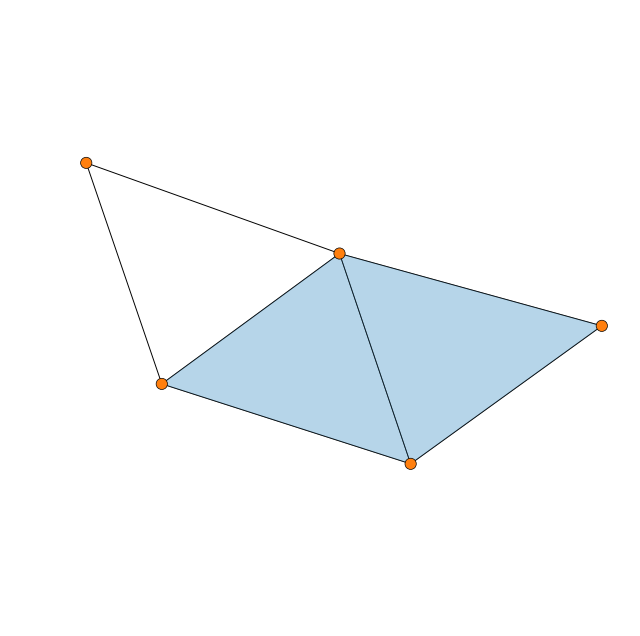

In [18]:
sc.draw_2d()

In [19]:
edge_set = [[1, 2], [1, 3]]
face_set = [[2, 3, 4], [2, 4, 5]]
edge_set + face_set

[[1, 2], [1, 3], [2, 3, 4], [2, 4, 5]]